In [1]:
from datetime import datetime
import librosa.display
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import random


# 1. 資料加載與標記

In [2]:
def load_segmented_files(directory, target_sr=32000):
    wav_files = []
    leak_wav_files = []
    print(f"共有 {len(os.listdir(directory))} 個資料夾")
    for dir in os.listdir(directory):
        if not os.path.isdir(os.path.join(directory, dir)):
            continue
        print(f"正在處理 {dir} 資料夾，共有 {len(os.listdir(os.path.join(directory, dir)))} 個檔案")
        for file in tqdm(os.listdir(os.path.join(directory, dir))):
            if not file.endswith(".wav"):
                continue
            file_path = os.path.join(directory, dir, file)
            y, sr = librosa.load(file_path, sr=None, mono=True)
            if sr != target_sr:
                    y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            filename = f'{dir}_{file}'
            # y_filt = bandpass_filter(y, sr=target_sr, lowcut=10, highcut=1500)
            if 'Leak' in dir:
                leak_wav_files.append((y, target_sr, filename))
            else:
                wav_files.append((y, target_sr, filename))
    print(f"共有 {len(wav_files) + len(leak_wav_files)} 個 wav 檔案，其中 {len(leak_wav_files)} 個有泄漏，{len(wav_files)} 個沒有泄漏")
    return wav_files, leak_wav_files 


# 比較數量，均衡資料
def balance_shuffle_data(wav_files, leak_wav_files):
    min_count = min(len(wav_files), len(leak_wav_files))
    wav_files = random.sample(wav_files, min_count)
    leak_wav_files = random.sample(leak_wav_files, min_count)
    
    print(f"均衡後的樣本數: {min_count}")
    return wav_files, leak_wav_files


def create_dataset(directory):
    wav_files, leak_wav_files = load_segmented_files(directory)
    wav_files, leak_wav_files = balance_shuffle_data(wav_files, leak_wav_files)
    
    # 將資料轉為 NumPy 格式
    X = []
    y = []
    
    for audio, sr, filename in wav_files:
        X.append((audio, sr))
        y.append(0)  # wav_files 標記為 0
    
    for audio, sr, filename in leak_wav_files:
        X.append((audio, sr))
        y.append(1)  # leak_wav_files 標記為 1
    
    np.bincount(y)
    return np.array(X, dtype=object), np.array(y)


# 2. 特徵提取與資料預處理

In [3]:
from tqdm import tqdm
from data_preprocess import extract_features, extract_stft_features

def preprocess_data(X, desired_time=2.0, n_mels=128, n_fft=2048, hop_length=512):
    features = []
    for audio, sr in tqdm(X):
        feature = extract_features(audio, sr, desired_time=desired_time, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        features.append(feature)
    return np.array(features)


In [4]:
def create_training_data(X,y, desired_time=2.0,  n_mels=128, n_fft=2048, hop_length=512):
    
    print(f"總樣本數: {len(X)}")
    print(f"標籤分佈: {np.bincount(y)}")
    
    
    X_features = preprocess_data(X, desired_time=desired_time, n_mels= n_mels, n_fft=n_fft, hop_length=hop_length)
    
    print(f"特徵形狀: {X_features.shape}")  # 預期形狀: (樣本數, max_len, n_mels)
    
    # 正規化特徵
    X_features = (X_features - np.mean(X_features)) / np.std(X_features)
    
    # 擴展維度以符合 CNN 輸入 (樣本數, 高, 寬, 通道)
    X_features = np.expand_dims(X_features, -1)  # 新形狀: (樣本數, max_len, n_mels, 1)
    
    # 分割訓練集與測試集
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2)
    
    print(f"訓練集形狀: {X_train.shape}")
    print(f"測試集形狀: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [5]:
X, y = create_dataset('raw_train')

共有 5 個資料夾
正在處理 CurrentSound 資料夾，共有 2429 個檔案


100%|██████████| 2429/2429 [01:50<00:00, 21.88it/s]


正在處理 Environment 資料夾，共有 588 個檔案


100%|██████████| 588/588 [00:38<00:00, 15.10it/s]


正在處理 GAS 資料夾，共有 99 個檔案


100%|██████████| 99/99 [00:09<00:00, 10.48it/s]


正在處理 Leak 資料夾，共有 3629 個檔案


100%|██████████| 3629/3629 [03:12<00:00, 18.90it/s]


正在處理 TrafficSound 資料夾，共有 129 個檔案


100%|██████████| 129/129 [00:08<00:00, 15.91it/s]

共有 6874 個 wav 檔案，其中 3629 個有泄漏，3245 個沒有泄漏
均衡後的樣本數: 3245


In [6]:
from dotenv import load_dotenv
load_dotenv()
desired_time = float(os.getenv('DESIRED_TIME'))
n_mels = int(os.getenv('N_MELS'))
n_fft = int(os.getenv('N_FFT'))
hop_length = int(os.getenv('HOP_LENGTH'))

X_train, X_test, y_train, y_test = create_training_data(X, y, desired_time=2.0, n_mels=128, n_fft=1024, hop_length=256)

總樣本數: 6490
標籤分佈: [3245 3245]


  0%|          | 0/6490 [00:00<?, ?it/s]C:\Users\User\miniconda3\envs\leak_detection\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
100%|██████████| 6490/6490 [00:48<00:00, 134.98it/s]


特徵形狀: (6490, 256, 128)
訓練集形狀: (5192, 256, 128, 1)
測試集形狀: (1298, 256, 128, 1)


# 3. 建立 CNN 模型

In [7]:
from keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model(input_shape):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    input_img = tf.keras.layers.Input(shape=input_shape)
 
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=input_img, outputs=x)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [8]:
def create_model(mockup_input):    
    # 建立模型
    input_shape = (mockup_input.shape[1], mockup_input.shape[2], 1)
    print(f"模型輸入形狀: {input_shape}")
    model = create_cnn_model(input_shape)
    model.summary()
    return model

# 4. 訓練模型

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


def train_model(model, X_train, X_test, y_train, y_test, epochs=30, batch_size=32):
        # 訓練模型
        
    early_stopping = EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
        
    history = model.fit(   
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        shuffle=True,
        callbacks=[early_stopping, reduce_lr],
        verbose=2
    )
    
    # 評估模型
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.2f}")
    
    return model, history

In [10]:
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.2f}")

In [11]:
cnn_model = create_model(X_train)

模型輸入形狀: (256, 128, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 64, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 64, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 64, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 32, 32)       0         
 2D)                                   

In [12]:
model, history = train_model(cnn_model, X_train, X_test, y_train, y_test, epochs=100, batch_size=64)

Epoch 1/100
82/82 - 16s - loss: 0.6133 - accuracy: 0.6312 - val_loss: 0.5603 - val_accuracy: 0.7673 - lr: 0.0010 - 16s/epoch - 189ms/step
Epoch 2/100
82/82 - 4s - loss: 0.4539 - accuracy: 0.7980 - val_loss: 0.3910 - val_accuracy: 0.8151 - lr: 0.0010 - 4s/epoch - 54ms/step
Epoch 3/100
82/82 - 5s - loss: 0.4144 - accuracy: 0.8228 - val_loss: 0.4560 - val_accuracy: 0.7935 - lr: 0.0010 - 5s/epoch - 56ms/step
Epoch 4/100
82/82 - 4s - loss: 0.3949 - accuracy: 0.8247 - val_loss: 0.4017 - val_accuracy: 0.8228 - lr: 0.0010 - 4s/epoch - 54ms/step
Epoch 5/100
82/82 - 4s - loss: 0.3930 - accuracy: 0.8234 - val_loss: 0.3786 - val_accuracy: 0.8351 - lr: 0.0010 - 4s/epoch - 53ms/step
Epoch 6/100
82/82 - 4s - loss: 0.3726 - accuracy: 0.8372 - val_loss: 0.3628 - val_accuracy: 0.8305 - lr: 0.0010 - 4s/epoch - 54ms/step
Epoch 7/100
82/82 - 4s - loss: 0.3628 - accuracy: 0.8444 - val_loss: 0.3692 - val_accuracy: 0.8220 - lr: 0.0010 - 4s/epoch - 54ms/step
Epoch 8/100
82/82 - 4s - loss: 0.3539 - accuracy: 0.

In [13]:
evaluate_model(cnn_model, X_test, y_test)
history.history['val_accuracy'][-1]

41/41 [==============================] - 0s 8ms/step - loss: 0.2858 - accuracy: 0.8867
Test loss: 0.2858
Test accuracy: 0.89


0.8836671710014343

In [16]:
date = datetime.now().strftime('%Y%m%d%H%M')
val_acc = history.history['val_accuracy'][-1]
model.save(f'model_mel_{date}_acc_{val_acc:.2f}.h5')
print(f"Model saved as model_mel_{date}_acc_{val_acc:.2f}.h5")

Model saved as model_mel_202411121722_acc_0.88.h5


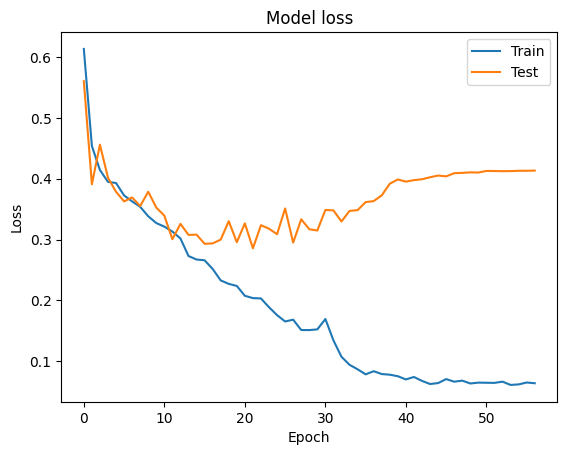

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig(f'model_mel_loss_{date}_acc_{val_acc:.2f}.png')
plt.show()